# Improve Model Performance Using Boosting and Stacking

# challenge

In this practice, Boosting with Adaboost and Stacking for Classification is used. To compare the results, we will also evaluate a simple Decision Tree and Bagging with Random Forest.

In [ ]:
# general imports
# general imports
import pandas as pd
import numpy as np
from matplotlib import pyplot
from numpy import mean
from numpy import std
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# evaluation imports
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

### 1. Load the Data

In [ ]:
# data imports
#from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
# load data
data_df1=pd.read_csv('/content/sample_data/DS2_C5_S7_AllRent_Data_Challenge.csv',error_bad_lines=False, engine="python")
data_df1.head()
data_df=data_df1

In [ ]:
data_df.columns

Index(['Unnamed: 0', 'bathrooms', 'bedrooms', 'building_id', 'created',
       'description', 'display_address', 'features', 'latitude', 'listing_id',
       'longitude', 'manager_id', 'photos', 'price', 'street_address',
       'interest_level'],
      dtype='object')

In [ ]:
data_df.dtypes

Unnamed: 0           int64
bathrooms          float64
bedrooms             int64
building_id         object
created             object
description         object
display_address     object
features            object
latitude            object
listing_id          object
longitude           object
manager_id          object
photos              object
price               object
street_address      object
interest_level      object
dtype: object

In [ ]:
data_df.head()

,Unnamed: 0,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
0,105408,1.0,0,0f9d07991ba14c82d3d368b72d90270a,04-04-2016 03:34,Gorgeous unit in one of the most genuinely cov...,230 Central Park South,"['Cats Allowed', 'Dogs Allowed', 'Doorman', 'E...",40.7672,6827153,-73.9802,932589de9230b697808216774fa26bd4,['https://photos.renthop.com/2/6821519_0a14cc2...,2800,230 Central Park South,high
1,110219,1.0,1,564d6f608f41e8d4a5e181c4e068e3d9,21-04-2016 20:40,Enormous 1 bedroom apartment in Murray Hill. F...,E 39th St,"['Cats Allowed', 'Dogs Allowed', 'Reduced Fee'...",40.7483,6908998,-73.9741,489ad933197469ae66acd1f7ce18f908,['https://photos.renthop.com/2/6908998_6b00895...,2100,243 E 39th St,high
2,56113,1.0,1,69790fbf0bf7e22b1d0ebc721cf0f633,14-05-2016 05:44,"This 1 bedroom, 1 bathroom spacious apartment ...",E 25th St.,"['Elevator', 'Furnished', 'Hardwood Floors']",40.7399,7013774,-73.9812,792c0f1ad1431397c65db3e69b770928,['https://photos.renthop.com/2/7013774_e7ead5d...,3000,217 E 25th St.,high
3,37765,1.0,2,d0234abbc01a982d54e8d446acc03405,05-06-2016 03:37,SPECTACULAR2 BEDROOM APARTMENT IN LUXURY 24HR ...,West 34th Street,"['Doorman', 'Elevator', 'Dishwasher', 'Hardwoo...",40.7530,7113518,-73.9958,eb5a6c4c2eb6f3e2a085c477afd5a815,['https://photos.renthop.com/2/7113518_d234153...,3000,360 West 34th Street,high
4,67397,1.0,2,a36895b9975c6991ca0fa1d9a99023a1,26-05-2016 05:36,NO FEE.. Newly Reno XL Convertible 2 Br .. Pri...,East 72nd Street,"['Dining Room', 'Doorman', 'Elevator', 'Fitnes...",40.7695,7071666,-73.9603,0a6ba20b892ed61df751420934d1ab51,['https://photos.renthop.com/2/7071666_4f81618...,3300,200 East 72nd Street,high


In [ ]:
#Checking null values
data_df.isnull().sum()

Unnamed: 0           0
bathrooms            0
bedrooms             0
building_id          0
created              0
description        286
display_address     34
features             0
latitude             0
listing_id           0
longitude            0
manager_id           0
photos               0
price                0
street_address       5
interest_level       0
dtype: int64

In [ ]:
data_df['created']=data_df['created'].astype('category')
data_df['interest_level']=data_df['interest_level'].astype('category')
data_df['latitude']=data_df['latitude'].astype('category')
data_df['longitude']=data_df['longitude'].astype('category')

In [ ]:
data_df["created"] = data_df["created"].str.slice(6,10)

In [ ]:
data_df['created']=data_df['created'].astype('int64')
data_df['latitude']=data_df['latitude'].astype('float64')
data_df['longitude']=data_df['longitude'].astype('float64')

#### Since the label is categorical, it must be encoded as numbers. As the result, malignant is set to 1 and benign to 0.

In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'interest_level'.
data_df['interest_level_encode']= label_encoder.fit_transform(data_df['interest_level'])
data_df['interest_level_encode'].unique()

array([0, 1, 2])

In [ ]:
#Features relevant to the problem is chosen
X=data_df[['bathrooms','bedrooms','created','latitude','longitude','price']]
y=data_df['interest_level']

### Learn Ensembles

all models are evaluated using repeated stratified k-fold cross-validation, with three repeats and 10 folds. 

the mean and standard deviation of the F1-Score of the model across all repeats and folds are recorded

In [ ]:
# define lists to gather results for plotting later
results, names = list(), list()

### 2. Baseline: Logistic Regression (For comparison)

In [ ]:
# define the model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('F1-Score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

F1-Score: 0.587 (0.007)


In [ ]:
# Baseline : DecisionTree classifier
# define the model
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('F1-Score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

F1-Score: 0.635 (0.011)


### 3.Bagging with Random forest

In [ ]:
# define the model
from sklearn.ensemble import RandomForestClassifier
 
# create regressor object
model = RandomForestClassifier() 

# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('F1-Score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

F1-Score: 0.659 (0.012)


### 4. Boosting with Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:

# define the model
model = AdaBoostClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1, error_score='raise')
results.append(n_scores)
names.append('ada')
# report performance
print('F1-Score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

F1-Score: 0.620 (0.008)


## Task 5. Stacking

In [ ]:
# required Python libraries
# required Python libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier

In [ ]:

# get a stacking ensemble of models
def get_stacking():
# define the base models
    level0 = list()
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('cart', DecisionTreeClassifier()))
    level0.append(('svr', SVC()))
# define meta learner model
    level1 = LogisticRegression()
# define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [ ]:
# define the model
model = get_stacking()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1, error_score='raise')
results.append(n_scores)
names.append('stacking')
# report performance
print('F1-Score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


F1-Score: 0.614 (0.009)


In [ ]:
results[0]

array([0.6224223 , 0.61069925, 0.63063023, 0.62443432, 0.62402688,
       0.62302741, 0.60088789, 0.61233206, 0.62358655, 0.61648579,
       0.62146565, 0.62169111, 0.64492008, 0.6302737 , 0.62430772,
       0.60776213, 0.61126099, 0.61512691, 0.6193362 , 0.61852844,
       0.62035099, 0.6187847 , 0.62277461, 0.62258744, 0.62584554,
       0.61456704, 0.61281493, 0.62186387, 0.6173322 , 0.62114804])

The following models are compared

1. Baseline - Logistic Regression
2.Baselinne - Decision Tree
3.Bagging - RandomForest
4.Boosting - Adaboost
5.Stacking

All these models are compared against the F1 score.
The F1-score combines the precision and recall of a classifier into a single metric by taking their harmonic mean. It is primarily used to compare the performance of two classifiers.

The bagging method performs better than above mentioned classifiers.

### 3. Plot for Final Comparison

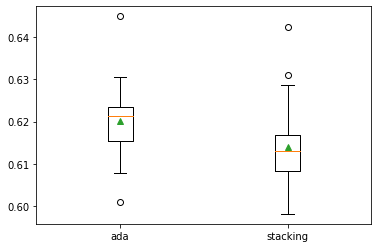

In [ ]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

The box plot shows the distribution of f1 score for each of the stratifiedkfold cross validation for Adaboost and stacking techniques

For Ada, the 75% of the times, the F1 score is below 0.62 ie below Q2(Median)
For stacking, The F1 score is near uniformly distributed. 